<a href="https://colab.research.google.com/github/BimsaraS99/Malaria-Detection-Image-Classifier-Deep-Learning-Model-using-Tensorflow-/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam

## **Dataset Preparation**

In [43]:
dataset, dataset_info = tfds.load('malaria', with_info=True, shuffle_files=True, as_supervised=True, split=['train'])
print(dataset)
print(dataset_info)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
  

In [44]:
def splits(dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    DATASET_SIZE = len(list(dataset))

    train_size = int(train_ratio * DATASET_SIZE)
    train_dataset = dataset.take(train_size)

    val_test_dataset = dataset.skip(train_size)
    val_size = int(val_ratio * DATASET_SIZE)
    val_dataset = val_test_dataset.take(val_size)

    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [45]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [46]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [47]:
print(f'Dataset size: {len(list(dataset))}')
print(f'Train size: {len(list(train_dataset))}')
print(f'Val size: {len(list(val_dataset))}')
print(f'Test size: {len(list(test_dataset))}')


Dataset size: 1
Train size: 22046
Val size: 2755
Test size: 2757


## **Dataset Visualization**

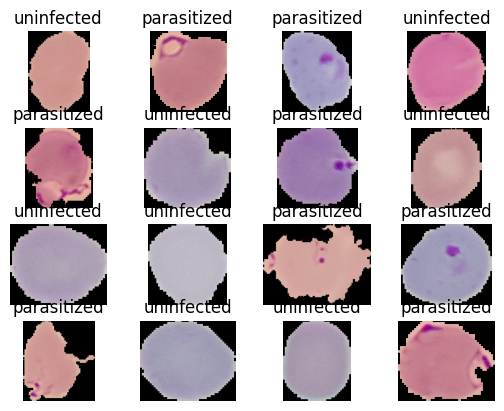

In [49]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## **Data Processing**

Convert all images in to same width and height (All images to 224 x 224 pixels)

Normalization / standardization (Feature scalling [link text](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Fmlearning-ai%2Fstandardization-vs-normalization-907bb0f3c74a&psig=AOvVaw1Y_12vu99zTJH41kBsKPGz&ust=1703850437759000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCKDsr5mIsoMDFQAAAAAdAAAAABAl))

For this problem we are going to use the normalization since this is a image classifer problem.

In [50]:
IM_SIZE = 224

def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [51]:
for image, label in train_dataset.take(1): # before convert to 224 x 224 pixels
  print(image.shape, label)

(103, 103, 3) tf.Tensor(1, shape=(), dtype=int64)


The image is converted to a tensor of type float32. The values of the pixels are in the range [0, 255]. Dividing the image by 255.0 rescales the pixel values to the range [0, 1].

In [52]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [53]:
for image, label in train_dataset.take(1): # after convert to 224 x 224 pixels
  print(image.shape, label)

(224, 224, 3) tf.Tensor(0, shape=(), dtype=int64)


In [54]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

The code you provided is a data loading pipeline for a TensorFlow model. It shuffles the training dataset, batches it into batches of size 32, and prefetches the next batch while the model is training. This helps to improve the performance of the model by reducing the amount of time spent waiting for data.

Here is a breakdown of the code:

**train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True):** This shuffles the training dataset so that each batch is a random sample of the data. The buffer size of 8 means that the dataset will be shuffled in batches of size 8. The reshuffle_each_iteration=True flag means that the dataset will be shuffled before each epoch.

**train_dataset.batch(32):** This batches the training dataset into batches of size 32. This is important because it helps to reduce the amount of time spent waiting for data.

**train_dataset.prefetch(tf.data.AUTOTUNE):** This prefetches the next batch of data while the model is training. This helps to improve the performance of the model by reducing the amount of time spent waiting for data.


## **Model Architeture Development**

In [22]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)), #input layer

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'), # convolutional layer 1 No of parameters 456 six bias
    MaxPool2D(pool_size=2, strides=2), # max pooling to half
    BatchNormalization(),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'), # convolutional layer 1 No of parameters 2400 weights + 16 bias
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2), # max pooling to half

    Flatten(), # flatting the matrices to hidden layers

    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 111, 111, 6)       24        
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

## **Loss Function**

Regression Loss Functions:
**Mean Squared Error (MSE):**
Measures the average squared difference between predicted and true values.

**Mean Absolute Error (MAE):**
Measures the average absolute difference between predicted and true values.


Binary Classification Loss Function:

**Binary Cross-Entropy (Logistic Loss):**
Suitable for binary classification problems, it measures the difference between predicted probabilities and true binary labels.
Multi-Class Classification Loss Functions:

**Categorical Cross-Entropy:**
Suitable for multi-class classification with mutually exclusive classes, measures the difference between predicted class probabilities and true one-hot encoded labels.

**Sparse Categorical Cross-Entropy:**
Similar to categorical cross-entropy but suitable when labels are integers (class indices) instead of one-hot encoded vectors.

Users can create their own loss functions based on the specific requirements of their problem.
Choosing the appropriate loss function depends on the task at hand (regression, binary classification, multi-class classification) and the characteristics of the data. Additionally, some loss functions are more suitable for handling certain challenges, such as class imbalance or outliers. The selection of a loss function often involves experimentation and consideration of the problem's characteristics.

**Sinec this is a binary classification problem, we can use the Binary Cross-Entropy (Logistic Loss)**

below cell not related to the code, it shows how the bce works (only the just below cell)

In [23]:
y_true = [0, ]
y_pred = [1.0,]
bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
print(bce)

tf.Tensor(15.333239, shape=(), dtype=float32)


In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryFocalCrossentropy(),
    metrics = "accuracy",
)


In [27]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=1)

Epoch 1/50
689/689 [==============================] - 47s 63ms/step - loss: 0.1143 - accuracy: 0.7969 - val_loss: 0.1524 - val_accuracy: 0.7735
Epoch 2/50
689/689 [==============================] - 43s 62ms/step - loss: 0.1209 - accuracy: 0.7570 - val_loss: 0.1653 - val_accuracy: 0.6011
Epoch 3/50
689/689 [==============================] - 42s 61ms/step - loss: 0.1453 - accuracy: 0.7006 - val_loss: 0.4000 - val_accuracy: 0.5452
Epoch 4/50
689/689 [==============================] - 42s 61ms/step - loss: 0.1021 - accuracy: 0.8236 - val_loss: 0.7934 - val_accuracy: 0.6327
Epoch 5/50
689/689 [==============================] - 42s 60ms/step - loss: 0.0637 - accuracy: 0.9127 - val_loss: 0.0636 - val_accuracy: 0.9238
Epoch 6/50
689/689 [==============================] - 50s 73ms/step - loss: 0.0563 - accuracy: 0.9239 - val_loss: 0.1387 - val_accuracy: 0.7002
Epoch 7/50
689/689 [==============================] - 42s 61ms/step - loss: 0.0544 - accuracy: 0.9254 - val_loss: 0.0563 - val_accuracy:

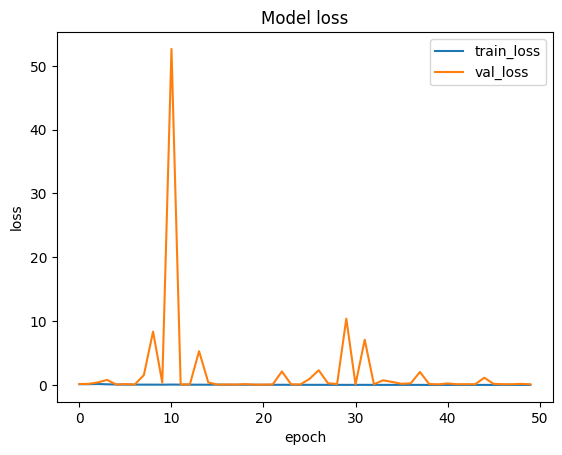

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

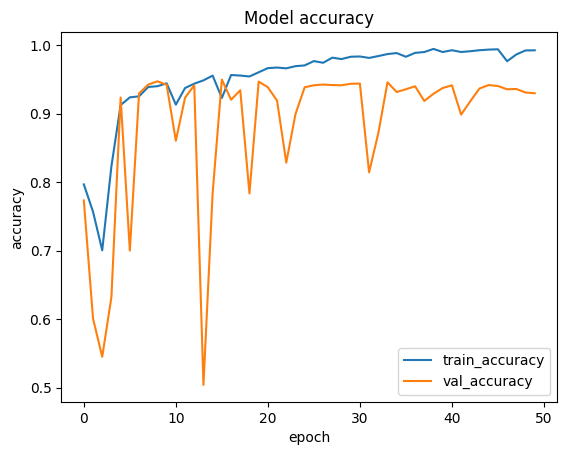

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## **Model Evaluation and Testing**

In [55]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [56]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [57]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [58]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 20s 4ms/step - loss: 0.2178 - accuracy: 0.9213


[0.21775925159454346, 0.9212912321090698]

In [64]:
def parasite_or_not(x):
  if (x < 0.5): return str('P')
  else: return str('U')

In [65]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 17ms/step


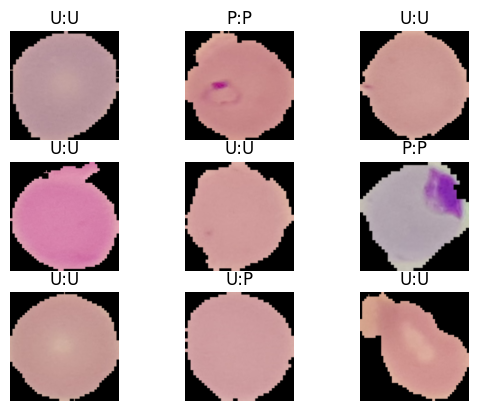

In [67]:
for i, (image, label) in enumerate (test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

1/1 [==============================] - 0s 19ms/step


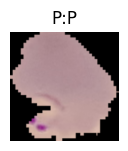

In [70]:
for i, (image, label) in enumerate (test_dataset.take(1)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [71]:
model.save("lenet")

In [72]:
loaded_model = tf.keras.models.load_model("lenet")
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 111, 111, 6)       24        
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

1/1 [==============================] - 0s 116ms/step


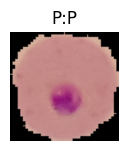

In [73]:
for i, (image, label) in enumerate (test_dataset.take(1)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(loaded_model.predict(image)[0][0])))
  plt.axis('off')

In [78]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Load and preprocess the external image
img_path = '/content/aasa.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
print(parasite_or_not(predictions))

1/1 [==============================] - 0s 109ms/step
P
